# Transfer learning 
根据original data样本，建立模型，对test data进行普通/其他苹果判断
1. 数据增强，扩充标签为普通苹果的样本数量
2. 特征提取：利用VGG16模型提取特征
3. 图片批量处理
4. 使用kmeans模型进行分类
5. 基于标签数据矫正结果，并可视化
6. 利用meanshift模型进行分类
7. 利用PCA进行降维，建立模型

In [9]:
# 数据增强
from keras.preprocessing.image import ImageDataGenerator
path = 'transfer_data/original_data'
dst_path = 'transfer_data/gen_data'
data_gen = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.02,horizontal_flip=True,vertical_flip=True)
gen = data_gen.flow_from_directory(path,target_size=(224,224), batch_size=2,save_to_dir=dst_path,save_prefix='gen',save_format='jpg')
for i in range(100):
    gen.next()

Found 10 images belonging to 1 classes.


In [12]:
# load the image
from keras.utils import load_img, img_to_array
img_path = 'transfer_data/train_data/1.jpg'
img = load_img(img_path, target_size = (224,224))
type(img)

PIL.Image.Image

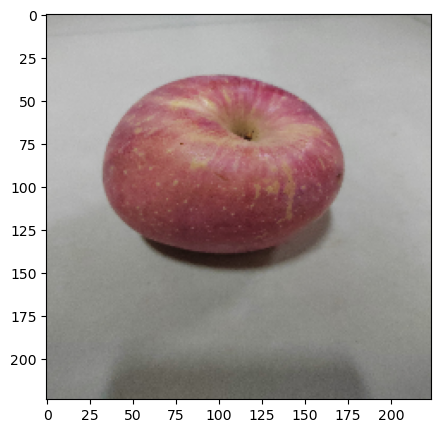

In [14]:
# show the image
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

In [16]:
img = img_to_array(img)
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(224, 224, 3)


In [18]:
# 特征提取
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
model_vgg = VGG16(weights='imagenet', include_top=False)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


In [19]:
features = model_vgg.predict(x)
print(features.shape)

1/1 [==============================] - 0s 385ms/step
(1, 7, 7, 512)


In [20]:
# flatten the features
features = features.reshape(1, 7*7*512)
print(features.shape)

(1, 25088)


In [62]:
# preprocessing the pictures by batch
import os
path = os.listdir('transfer_data/train_data')
img_fullpath=[]
for i in path:
     img_fullpath.append('transfer_data/train_data/' + i)
print(type(img_fullpath))

<class 'list'>


In [63]:
# preprocessing the pictures by batch
features_train = np.zeros([len(path),7*7*512])
for i in range(len(path)):
    img = load_img(img_fullpath[i], target_size = (224,224))
    img = img_to_array(img)
    x= np.expand_dims(img, axis=0)
    x=preprocess_input(x)
    features = model_vgg.predict(x)
    features = features.reshape(1, 7*7*512)
    features_train[i]=features
#print(features_train.shape)

1/1 [==============================] - 0s 162ms/step


In [64]:
print(features_train.shape)

(230, 25088)


In [65]:
# k-means算法进行分类 目前210个普通苹果20个其他的
x_kmeans = features_train
from sklearn.cluster import KMeans
model_kmeans = KMeans(n_clusters=2, max_iter=2000)
model_kmeans.fit(x_kmeans)


D:\anaconda3\envs\mykerasenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\envs\mykerasenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(max_iter=2000, n_clusters=2)

In [67]:
# make prediction
y_kmeans_predict = model_kmeans.predict(x_kmeans)
print(y_kmeans_predict)
# 计算结果的类别
from collections import Counter
print(Counter(y_kmeans_predict))

[1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0
 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1
 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0
 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
Counter({0: 116, 1: 114})


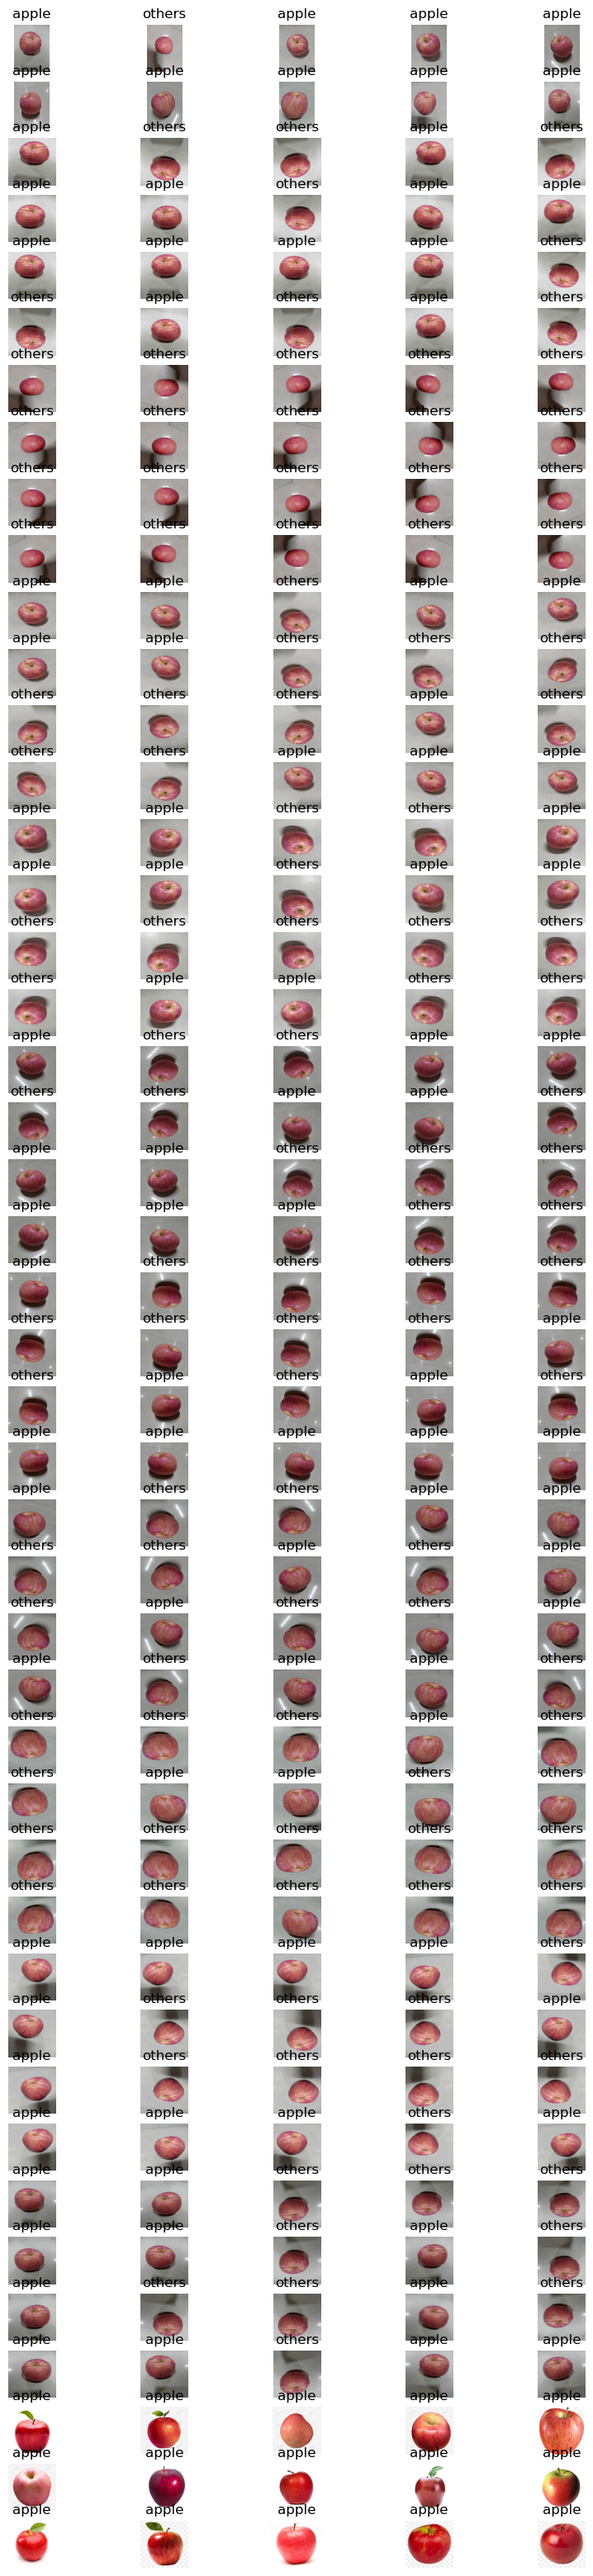

In [75]:
# visulize the data 
fig2 = plt.figure(figsize=(10,40))
for i in range(45):
    for j in range(5):
        img = load_img(img_fullpath[i*5+j])
        plt.subplot(45,5,i*5+j+1)
        plt.imshow(img)
        plt.title('apple' if y_kmeans_predict[i*5+j]==1 else 'others')
        plt.axis('off')

#plt.imshow(img)

plt.show()

In [77]:
# test the test data
path_test = os.listdir('transfer_data/test_data')
img_test_fullpath=[]
for i in path_test:
     img_test_fullpath.append('transfer_data/test_data/' + i)
print(len(img_test_fullpath))

12


In [78]:
# preprocessing the pictures by batch
features_test = np.zeros([len(path_test),7*7*512])
for i in range(len(path_test)):
    img = load_img(img_test_fullpath[i], target_size = (224,224))
    img = img_to_array(img)
    x= np.expand_dims(img, axis=0)
    x=preprocess_input(x)
    features = model_vgg.predict(x)
    features = features.reshape(1, 7*7*512)
    features_test[i]=features

1/1 [==============================] - 0s 139ms/step


In [84]:
x_test = features_test
y_test_predict = model_kmeans.predict(x_test)
print(y_test_predict)

[0 0 0 0 0 0 0 1 0 0 1 0]


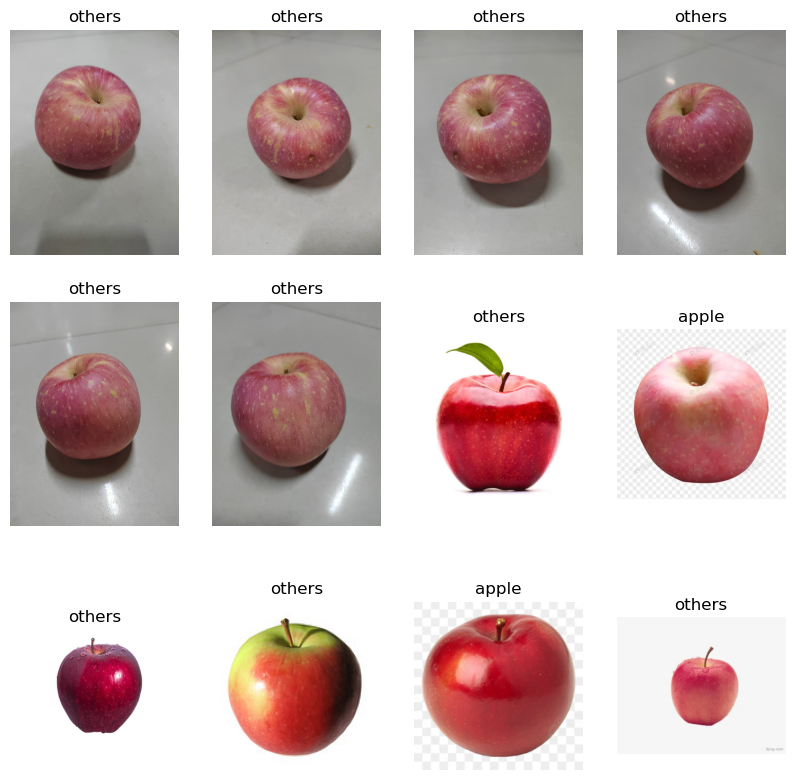

In [88]:
# visulize the test data 
fig3 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(img_test_fullpath[i*4+j])
        plt.subplot(3,4,i*4+j+1)
        plt.imshow(img)
        plt.title('apple' if y_test_predict[i*4+j]==1 else 'others')
        plt.axis('off')
plt.show()

In [91]:
# 重新利用meanshift算法进行聚类
from sklearn.cluster import MeanShift, estimate_bandwidth
# obtain the bandwidth
x_ms = x_kmeans
bw = estimate_bandwidth(x_ms,n_samples=140)
print(bw)
# setup the model
model_ms = MeanShift(bandwidth=bw)
model_ms.fit(x_ms)
print('OK')

1007.0576394637005
OK


In [93]:
# prediction and visulize
y_ms_predict = model_ms.predict(x_ms)
print(y_ms_predict)
print(Counter(y_ms_predict))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  7  8  6 10  9
 16 14 17 19 15 11 18  5  4  3  1  2 13  0]
Counter({0: 211, 12: 1, 7: 1, 8: 1, 6: 1, 10: 1, 9: 1, 16: 1, 14: 1, 17: 1, 19: 1, 15: 1, 11: 1, 18: 1, 5: 1, 4: 1, 3: 1, 1: 1, 2: 1, 13: 1})


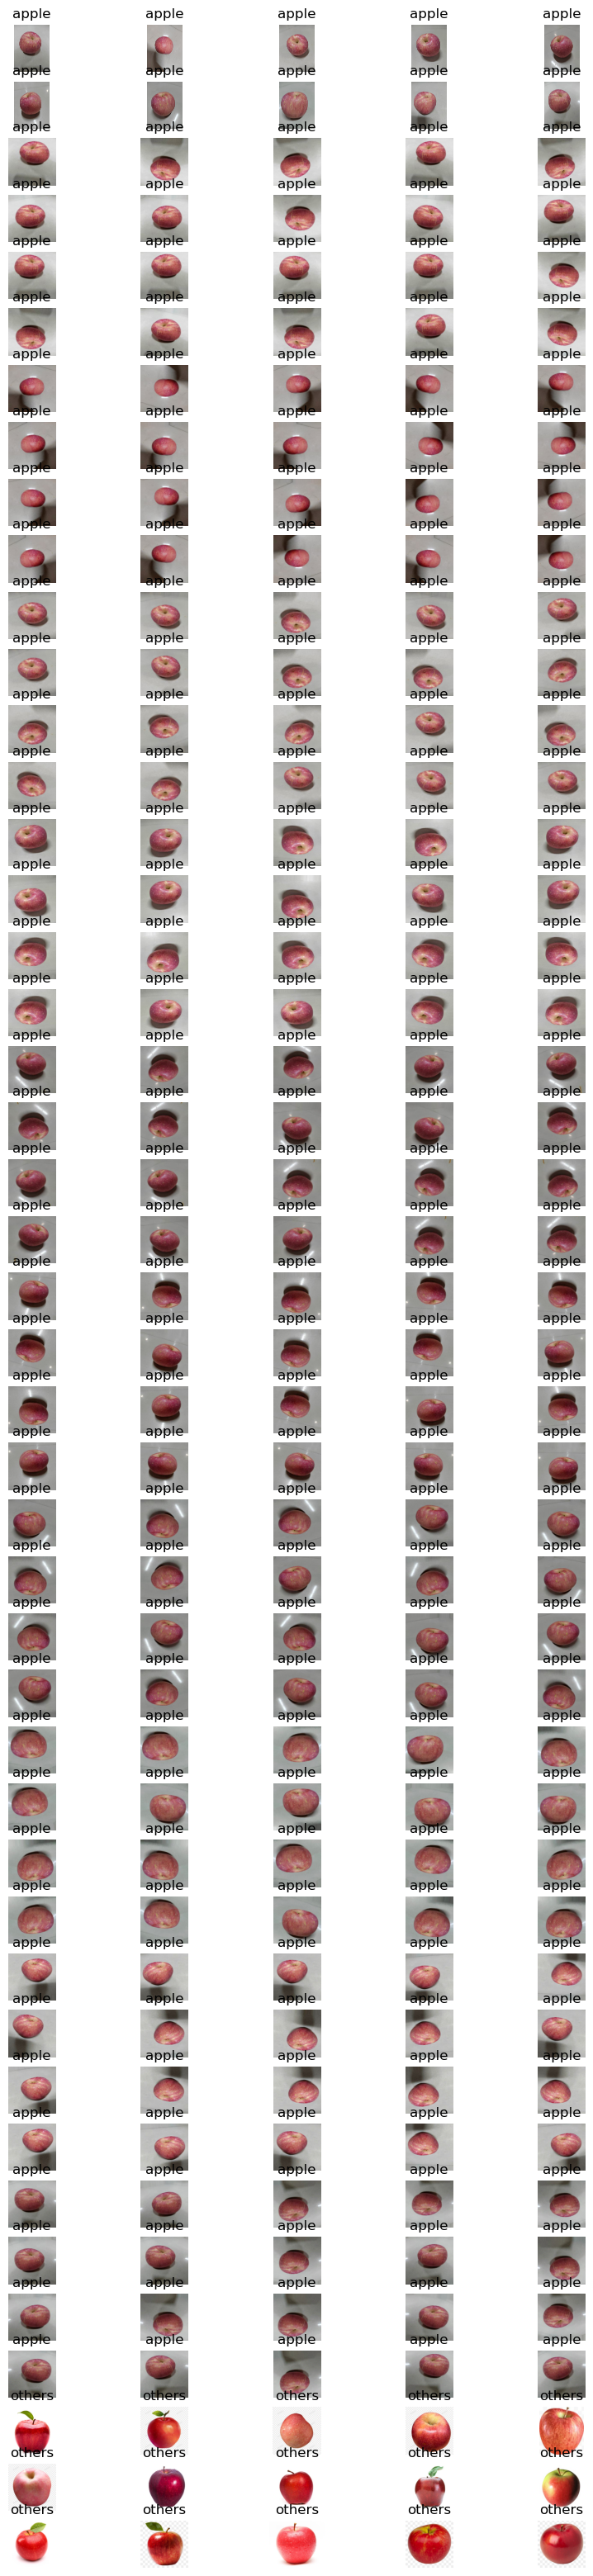

In [94]:
fig4 = plt.figure(figsize=(10,40))
for i in range(45):
    for j in range(5):
        img = load_img(img_fullpath[i*5+j])
        plt.subplot(45,5,i*5+j+1)
        plt.imshow(img)
        plt.title('apple' if y_ms_predict[i*5+j]==0 else 'others')
        plt.axis('off')
#plt.imshow(img)

plt.show()

In [95]:
# test the model
y_test_predict = model_ms.predict(x_test)
print(y_test_predict)

[ 0  0  0  0  0  0 12  9 16 19  4  0]


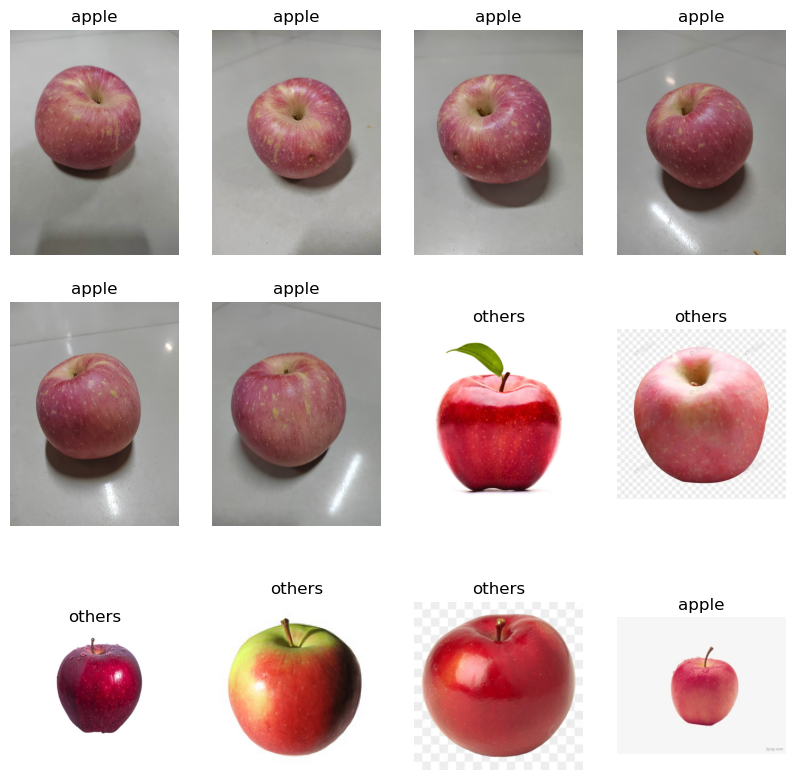

In [96]:
# visulize the test data 
fig5 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(img_test_fullpath[i*4+j])
        plt.subplot(3,4,i*4+j+1)
        plt.imshow(img)
        plt.title('apple' if y_test_predict[i*4+j]==0 else 'others')
        plt.axis('off')
plt.show()

In [108]:
# 利用PCA做噪音消除
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
stds = StandardScaler()
x_norm = stds.fit_transform(x_kmeans)
pca = PCA(n_components=200)
x_pca = pca.fit_transform(x_norm)


In [109]:
# calculate the variance ratio of each component
var_ratio = pca.explained_variance_ratio_
print(np.sum(var_ratio))

0.9789051439235592


In [110]:
print(x_pca.shape)

(230, 200)


In [111]:
# 重新利用meanshift算法进行聚类
from sklearn.cluster import MeanShift, estimate_bandwidth
# obtain the bandwidth
x_ms = x_pca
bw = estimate_bandwidth(x_ms,n_samples=140)
print(bw)
# setup the model
model_ms = MeanShift(bandwidth=bw)
model_ms.fit(x_ms)
print('OK')

174.521985840393
OK


In [112]:
# prediction and visulize
y_ms_pca_predict = model_ms.predict(x_ms)
print(y_ms_pca_predict)
print(Counter(y_ms_pca_predict))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 21
  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  7  9  0 10  1 15
 16  0 13 12  0  2 14  3  5  8  4  6 11  0]
Counter({0: 209, 18: 1, 21: 1, 19: 1, 20: 1, 17: 1, 7: 1, 9: 1, 10: 1, 1: 1, 15: 1, 16: 1, 13: 1, 12: 1, 2: 1, 14: 1, 3: 1, 5: 1, 8: 1, 4: 1, 6: 1, 11: 1})


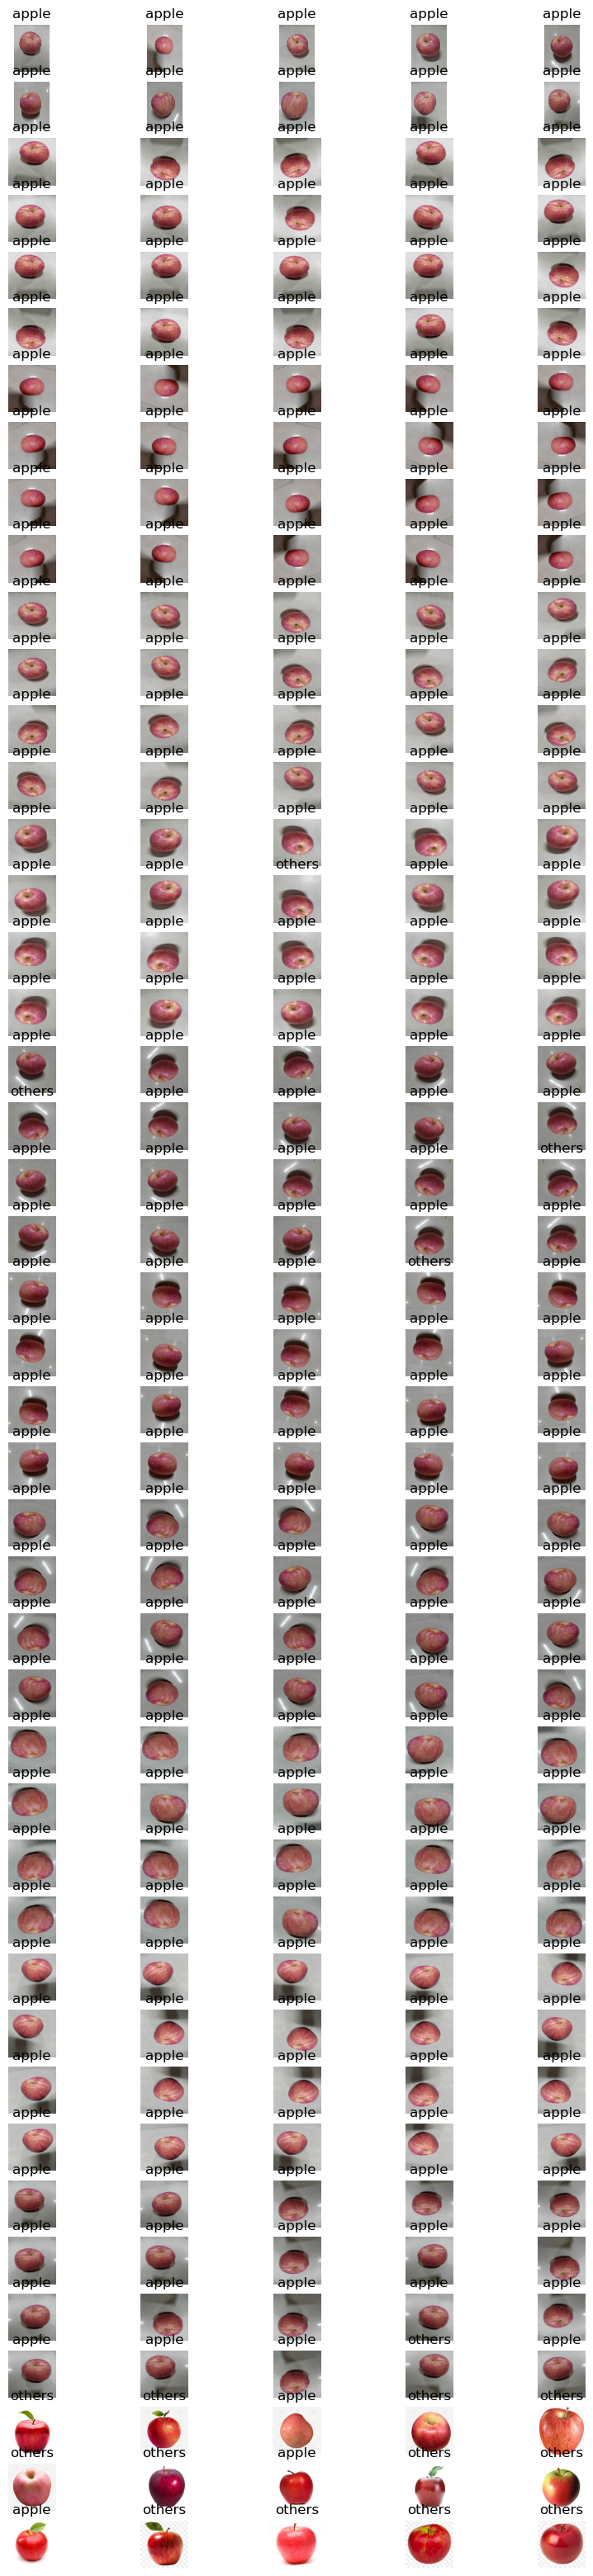

In [113]:
fig6 = plt.figure(figsize=(10,40))
for i in range(45):
    for j in range(5):
        img = load_img(img_fullpath[i*5+j])
        plt.subplot(45,5,i*5+j+1)
        plt.imshow(img)
        plt.title('apple' if y_ms_pca_predict[i*5+j]==0 else 'others')
        plt.axis('off')
#plt.imshow(img)

plt.show()

In [114]:
# test the model
x_norm_test = stds.transform(x_test)
x_pca_test = pca.transform(x_norm_test)
y_test_pca_predict = model_ms.predict(x_pca_test)
print(y_test_pca_predict)

[ 0  0  0  0  0  0  7 15 16 12  5  0]


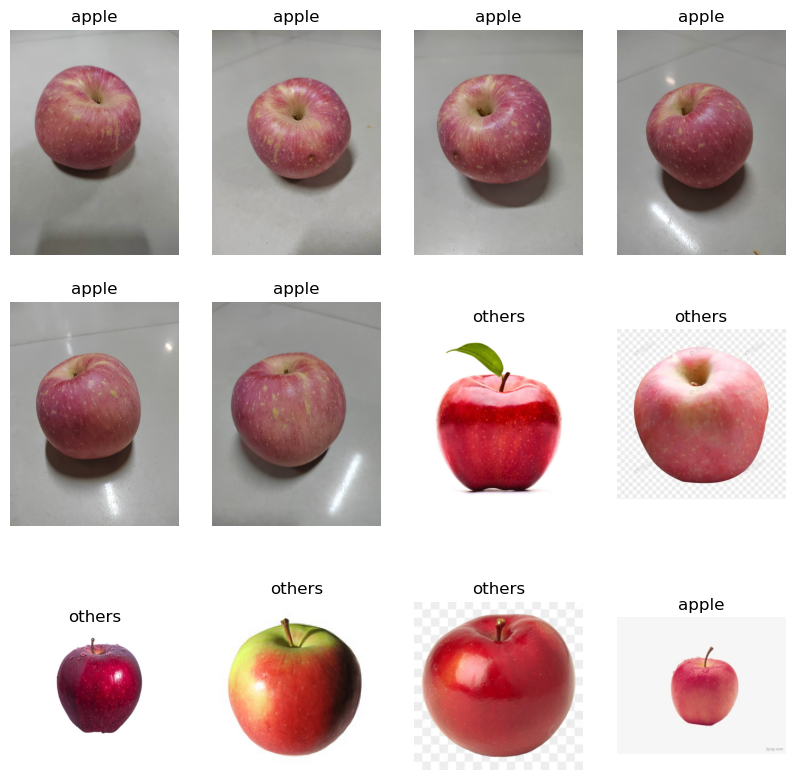

In [115]:
# visulize the test data 
fig7 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(img_test_fullpath[i*4+j])
        plt.subplot(3,4,i*4+j+1)
        plt.imshow(img)
        plt.title('apple' if y_test_pca_predict[i*4+j]==0 else 'others')
        plt.axis('off')
plt.show()